# Whiskey clustering with Apache Ignite

This example examines 86 Scotch whiskies that have been rated on
a five-point scale for 12 flavor characteristics: Body, sweetness, smoky, medicinal, tobacco, honey, spicy, winey, nutty, malty, fruity, and floral.
This data set comes from a book on the classification of Scotch whisky based on
flavors by David Wishart (2002) and can be found [online](https://www.niss.org/sites/default/files/ScotchWhisky01.txt).

We'll use [Apache Commons CSV](https://commons.apache.org/proper/commons-csv/) to read and manipulate our data
and the clustering classes from the [Apache Ignite](https://ignite.apache.org/)
[machine learning library](https://ignite.apache.org/features/machinelearning.html).

We'll add those libraries to the classpath and define some imports to simplify access to the classes we need.

In [ ]:
%%classpath add mvn
org.apache.ignite ignite-core 2.15.0
org.apache.ignite ignite-ml 2.15.0
org.apache.commons commons-csv 1.10.0
org.knowm.xchart xchart 3.8.3

In [ ]:
%import static org.apache.commons.csv.CSVFormat.RFC4180
%import java.awt.Color
%import org.knowm.xchart.*
%import org.apache.ignite.Ignition
%import org.apache.ignite.cache.affinity.rendezvous.RendezvousAffinityFunction
%import org.apache.ignite.configuration.CacheConfiguration
%import org.apache.ignite.configuration.IgniteConfiguration
%import org.apache.ignite.ml.clustering.kmeans.KMeansTrainer
%import org.apache.ignite.ml.dataset.feature.extractor.impl.DoubleArrayVectorizer
%import org.apache.ignite.ml.math.distances.*
%import org.apache.ignite.spi.discovery.tcp.TcpDiscoverySpi
%import org.apache.ignite.spi.discovery.tcp.ipfinder.multicast.TcpDiscoveryMulticastIpFinder

We start by loading the data.

In [ ]:
file = '../resources/whiskey.csv' as File
rows = file.withReader {r -> RFC4180.parse(r).records*.toList() }
data = rows[1..-1].collect{ it[2..-1]*.toDouble() } as double[][]
distilleries = rows[1..-1]*.get(1)
features = rows[0][2..-1]

[Body, Sweetness, Smoky, Medicinal, Tobacco, Honey, Spicy, Winey, Nutty, Malty, Fruity, Floral]

Next we configure our cluster (we'll use a single node for this simple demo).

In [ ]:
cfg = new IgniteConfiguration(
  peerClassLoadingEnabled: true,
  discoverySpi: new TcpDiscoverySpi(
    ipFinder: new TcpDiscoveryMulticastIpFinder(
      addresses: ['127.0.0.1:47500..47509']
    )
  )
)
OutputCell.HIDDEN

Then we'll define some helper variables:

In [ ]:
pretty = this.&sprintf.curry('%.4f')
vectorizer = new DoubleArrayVectorizer()
dist = new EuclideanDistance()
OutputCell.HIDDEN

Next, we'll start our cluster, populate the Ignite cache, and then perform the clustering:

In [ ]:
Ignition.start(cfg).withCloseable { ignite ->
    println ">>> Ignite grid started for data: ${data.size()} rows X ${data[0].size()} cols"
    def dataCache = ignite.createCache(new CacheConfiguration<Integer, double[]>(
          name: "TEST_${UUID.randomUUID()}",
          affinity: new RendezvousAffinityFunction(false, 10)))
    data.indices.each { int i -> dataCache.put(i, data[i]) }
    def trainer = new KMeansTrainer().withDistance(dist).withAmountOfClusters(3)
    def mdl = trainer.fit(ignite, dataCache, vectorizer)
    println ">>> KMeans centroids:\n${features.join(', ')}"
    def centroids = mdl.centers*.all()
    cols = centroids.collect{ it*.get() }
    cols.each { c -> println c.collect(pretty).join(', ') }
    dataCache.destroy()
}
OutputCell.HIDDEN

Jun 06, 2023 7:43:03 AM java.util.logging.LogManager$RootLogger log


[07:43:04]    __________  ________________ 
[07:43:04]   /  _/ ___/ |/ /  _/_  __/ __/ 
[07:43:04]  _/ // (7 7    // /  / / / _/   
[07:43:04] /___/\___/_/|_/___/ /_/ /x___/  
[07:43:04] 
[07:43:04] ver. 2.15.0#20230425-sha1:f98f7f35
[07:43:04] 2023 Copyright(C) Apache Software Foundation
[07:43:04] 
[07:43:04] Ignite documentation: https://ignite.apache.org
[07:43:04] 
[07:43:04] Quiet mode.
[07:43:04]   ^-- Logging by 'JavaLogger [quiet=true, config=null]'
[07:43:04]   ^-- To see **FULL** console log here add -DIGNITE_QUIET=false or "-v" to ignite.{sh|bat}
[07:43:04] 
[07:43:04] OS: Linux 5.15.0-69-generic amd64
[07:43:04] VM information: OpenJDK Runtime Environment 1.8.0_121-b15 Azul Systems, Inc. OpenJDK 64-Bit Server VM 25.121-b15
[07:43:04] Please set system property '-Djava.net.preferIPv4Stack=true' to avoid possible problems in mixed environments.
[07:43:07] Configured plugins:
[07:43:07]   ^-- ml-inference-plugin 1.0.0
[07:43:07]   ^-- null
[07:43:07] 
[07:43:07] Configured fa

Finally, let's graph the results as a radar plot.

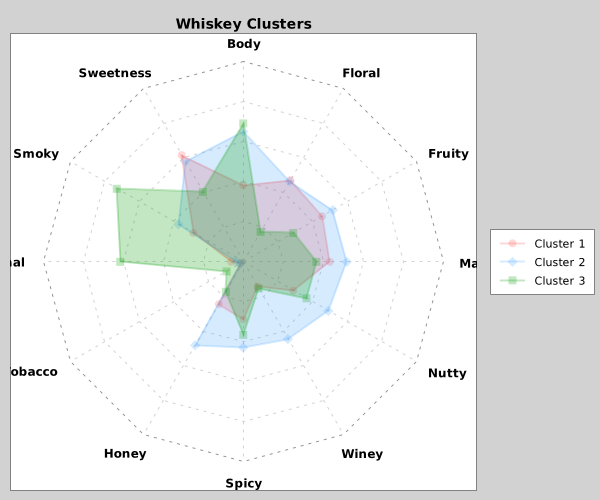

In [ ]:
def chart = new RadarChartBuilder().width(600).height(500).title('Whiskey Clusters').build()
chart.radiiLabels = features as String[]
chart.styler.with {
    legendVisible = true
    seriesColors = [new Color(255, 51, 51, 50),
                    new Color(51, 153, 255, 50),
                    new Color(0, 153, 0, 60)] as Color[]
}
cols.eachWithIndex { ctrd, num ->
    chart.addSeries("Cluster ${num+1}", ctrd.collect{ it/4 } as double[])
}
BitmapEncoder.getBufferedImage(chart)